## Batch Normalization
Batch normalization is a popular and effective way to make the deep network convergence. With the help of residue blocks,
 network can be designed deeper than 100 layers

In [6]:
import torch
from torch import nn
from d2l import torch as d2l

def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    if not torch.is_grad_enabled():
        # if under the evaluation mode, use the arguments sent in directly
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # when we use FC layers, calculate the means and variance in the feature dimension
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # when we use Conv2d, calculate the means and variances in the channel dimension
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # if under the training mode, use teh calculated means and variances to normalization
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # update the average mean and variance during the movement
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var

    Y = gamma * X_hat + beta  # scale and shift
    return Y, moving_mean.data, moving_var.data

In [3]:
# Batch normal layer
class BatchNorm(nn.Module):
    # num_features: output numbers of the FC layer or the output channels' number of the Conv layer
    # num_dims: 2 is FC layer, 4 is Conv layer
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # scale argument: gamma, bias argument: beta
        # initialize the scale and bias argument into 1 & 0 separately
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # non-model-params are initialized into 0 & 1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # if X is not in the memory of GPU, moving the moving_mean & moving_var to the memory X in
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # save teh updated moving_mean & moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(X, self.gamma, self.beta, self.moving_mean,
                                                          self.moving_var, 1e-5, 0.9)
        return Y

In [4]:
# use the LeNet with batch_norm
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10)
)

loss 0.269, train acc 0.899, test acc 0.862
24941.0 examples/sec on cuda


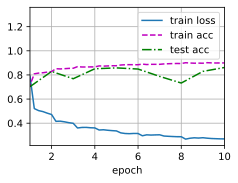

In [7]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, "cuda")

In [8]:
# gamma & beta in teh first batchnorm layer we obtained
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([1.9848, 3.1324, 0.6936, 2.5553, 2.9075, 3.1034], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>),
 tensor([ 1.7731, -3.5836,  1.0486, -2.2503, -1.5864,  2.1128], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>))

In [9]:
# use the batchNorm2d in Pytorch
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10)
)

loss 0.270, train acc 0.900, test acc 0.845
43282.3 examples/sec on cuda


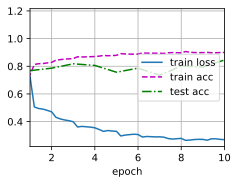

In [10]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, "cuda")